#### Import the required packages

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import persim
import seaborn as sns
import gudhi.representations
from persim.persistent_entropy import *
import gudhi as gd
import csv
import os
sns.set_style('darkgrid')
%matplotlib inline

# cmd = subprocess.Popen('pwd', stdout=subprocess.PIPE)
# cmd_out, cmd_err = cmd.communicate()
# local_path = os.fsdecode(cmd_out).strip()

#### Get the filenames and locations to load the persistence diagram datasets

In [2]:
directory_in_str = '../data/annotated_PH_2020_500/'

directory = os.fsencode(directory_in_str)
folders=[]

for folder in os.listdir(directory):
    foldername = os.fsdecode(folder)
    if foldername.startswith('PH_3_'):
        folders.append(foldername)

#### Get persistence data stored in files within the folder whose location is passed through the keyword argument path

In [3]:
number_of_edges_threshold = 0

"""
Returns persistence data
Inputs -- path: local_path
       -- starts_with: the string that the filenames start with if needed
       -- ends_with: the string that the filenames end with if needed
       -- threshold: number of edges threshold of the underlying vascular networks
"""

def get_data(path=None,starts_with=None,ends_with=None,threshold=None):
    files = [os.fsdecode(file) for file in os.listdir(path)]
    persistence_data={}
    for filename in files:
        if starts_with and ends_with:
            if filename.startswith(starts_with) and filename.endswith(ends_with):
                data = []
                with open(path+filename) as f:
                    reader = csv.reader(f)
                    for row in reader:
                        data.append([float(x) for x in row])
                if threshold == 0:
                    persistence_data[filename]=[item for item in data[1:] if item[1]!=np.inf]
                else:
                    if data[0][1] >= threshold:
                        persistence_data[filename]=[item for item in data[1:] if item[1]!=np.inf]
        elif starts_with:
            if filename.startswith(starts_with):
                data = []
                with open(path+filename) as f:
                    reader = csv.reader(f)
                    for row in reader:
                        data.append([float(x) for x in row])
                if threshold == 0:
                    persistence_data[filename]=[item for item in data[1:] if item[1]!=np.inf]
                else:
                    if data[0][1] >= threshold:
                        persistence_data[filename]=[item for item in data[1:] if item[1]!=np.inf]
        elif ends_with:
            if filename.endswith(ends_with):
                data = []
                with open(path+filename) as f:
                    reader = csv.reader(f)
                    for row in reader:
                        data.append([float(x) for x in row])
                if threshold == 0:
                    persistence_data[filename]=[item for item in data[1:] if item[1]!=np.inf]
                else:
                    if data[0][1] >= threshold:
                        persistence_data[filename]=[item for item in data[1:] if item[1]!=np.inf]
                
    return persistence_data

#### For analysis of vascular networks in bulk of mouse brain tissue in a region. The original networks are compared against networks with same topology but with edge weights redistributed randomly across the network

In [4]:
og_PHs={}
for folder in folders:
    og_PHs[folder] = get_data('../data/annotated_PH_2020_500/'+folder+'/',starts_with=('ph_'),threshold=number_of_edges_threshold)

shuffled_PHs={}
for folder in folders:
    shuffled_PHs[folder] = get_data('../data/annotated_PH_2020_500/'+folder+'/',starts_with=('shuffled_ph_'),threshold=number_of_edges_threshold)

#### Use the following helper function to get persistence data if it is stored within a dictionary of dictinoaries.

In [5]:
"""
Input -- persistence_data: a dictionary of folders consisting of dictionaries 
         of files whose values are the lists of persistence (b,d) pairs dataset
"""

def get_pd_aslist(persistence_data):
    pl_data = []
    for key,value in persistence_data.items():
        if value:
            for subkey,subvalue in value.items():
                pl_data.append(subvalue)
                if subvalue == []:
                    print(subkey)
    return pl_data

#### Loading the persistence data and creating the labels for classification

In [6]:
og_ph_dataset = get_pd_aslist(og_PHs)
shuffled_ph_dataset = get_pd_aslist(shuffled_PHs)

y=[]
for k in range(len(og_ph_dataset)+len(shuffled_ph_dataset)):
    if k < len(og_ph_dataset):
        y.append(0)
    elif k >= len(og_ph_dataset):
        y.append(1)
        
dataset = [np.array(item) for item in og_ph_dataset+shuffled_ph_dataset]

## Check that the number of samples
print((sum(y)/len(y),len(y)))

(0.5, 714)


#### Looking at the distribution of persistence entropies (PE) of vascular networks indicates if there is a distinction to be made between networks in region-1 vs. region-2. The concept of PE was first laid out in the followinig two paperes:

https://www.sciencedirect.com/science/article/abs/pii/S0031320314002453

https://link.springer.com/chapter/10.1007/978-3-319-29228-1_11

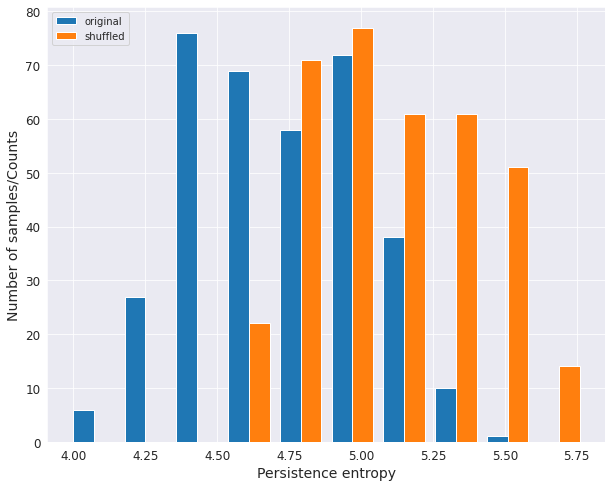

In [13]:
og_entropy = []
for data in dataset[:len(dataset)//2]:
    og_entropy.append(persistent_entropy(data)[0])
    
shuffled_entropy = []
for data in dataset[len(dataset)//2:len(dataset)]:
    shuffled_entropy.append(persistent_entropy(data)[0])

plt.figure(figsize=(10,8))    
plt.hist([og_entropy,shuffled_entropy],
         #bins = 20,
         # density=True,
         label=['original','shuffled'])
plt.xlabel('Persistence entropy',fontsize=14)
plt.ylabel('Number of samples/Counts',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper left')
plt.show()

#### 2-sample Kolmogrov-Smirnov test & Mann-Whitney U test indicate that the distrbutions are different.

https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test

https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test

In [84]:
from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu

stat, p_val= ks_2samp(og_entropy,shuffled_entropy)
print(f'kstest between entropy distributions: {stat, p_val}')
stat, p_val= mannwhitneyu(og_entropy,shuffled_entropy)
print(f'mannwhitneyu between entropy distributions: {stat, p_val}')

kstest between entropy distributions: (0.6190476190476191, 3.9497813910249487e-19)
mannwhitneyu between entropy distributions: (1506.0, 4.578301461022668e-20)


#### A box-plot can be used to examine distributions of PE

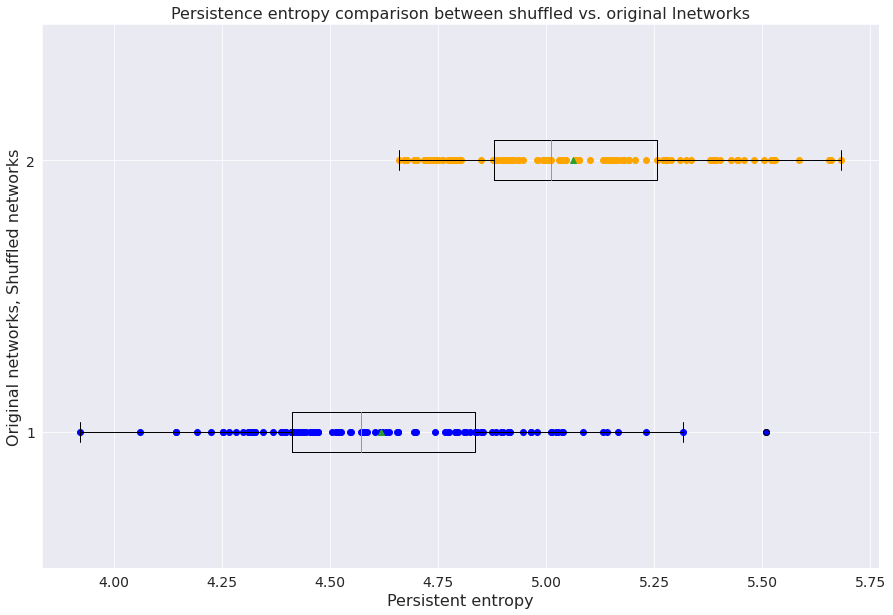

In [85]:
plt.figure(figsize=(15,10)) 
plt.boxplot([og_entropy,shuffled_entropy],vert=False,showmeans=True)
plt.scatter(og_entropy,np.ones(len(og_entropy)),c='b')
plt.scatter(shuffled_entropy,1+np.ones(len(shuffled_entropy)),c='orange')
plt.title('Persistence entropy comparison between shuffled vs. original lnetworks',fontsize=16)
plt.xlabel("Persistent entropy",fontsize=16)
plt.ylabel("Original networks, Shuffled networks",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('2018_BS_persistent_entropy.jpg');

#### Persistence landscapes. 

Persistence landscapees are piecewise linear functions that are generated using persistence diagrams. These are vectors in a Hilbert space and thus are amenable to training a machine learning algorithm (https://jmlr.org/papers/v16/bubenik15a.html).

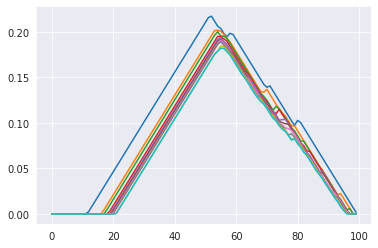

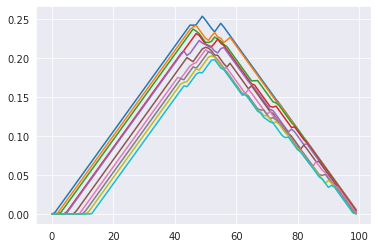

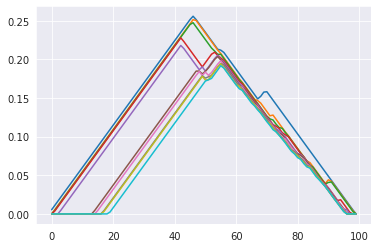

In [15]:
## Specify the resolution of the landscapes 
resolution = 100
## Specify the number of landscapes. The order of landscapes is inversely proportional to their persistence. 
num_landscapes = 10
LS = gd.representations.Landscape(resolution = resolution,num_landscapes=num_landscapes)
K = LS.num_landscapes

## Plot landscapes from the shuffled dataset
L = LS.fit_transform([dataset[-3],dataset[-1],dataset[-2]])
for idx, landscape in enumerate(L):
    for k in range(K):
        plt.plot(landscape[k*resolution: (k+1)*resolution])
    plt.show()

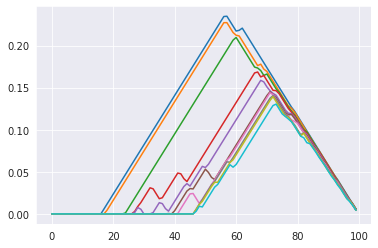

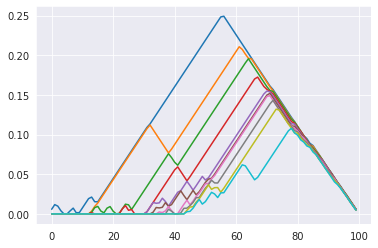

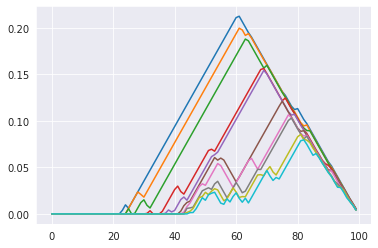

In [16]:
## Plot landscapes from the original dataset
L = LS.fit_transform([dataset[3],dataset[1],dataset[2]])
for idx, landscape in enumerate(L):
    for k in range(K):
        plt.plot(landscape[k*resolution: (k+1)*resolution])
    plt.show()

#### Train-test split

In [18]:
from sklearn.model_selection import train_test_split
import sklearn.metrics

ph_train, ph_test, y_train, y_test = train_test_split(dataset, y,
                                                      test_size = 0.1,
                                                      random_state=100,
                                                      shuffle=True,
                                                      stratify=y)

#### Machine learning pipeline. 
The design of the pipeline is guided by the some of the scripts in following repository: https://github.com/GUDHI/TDA-tutorial.

Finding optimal parameter setting through GridSearch CV

In [20]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

resolution = 10

pipe = Pipeline(steps=[
    ('scaler',gd.representations.DiagramScaler(scalers=[([0,1], MinMaxScaler())])),
    ('tda',gd.representations.Landscape()),
    ('classifier',LinearSVC(max_iter=50000))
])

param_grid = {
    'scaler__use':[True],
    'tda__resolution':[resolution],
    'tda__num_landscapes':[num_landscapes],
    'classifier__C':np.logspace(-2,3,10) 
}

model = GridSearchCV(pipe, param_grid, n_jobs=12, cv = 10, scoring='accuracy')
model.fit(ph_train,y_train)

0.9735336538461539 {'classifier__C': 0.464158883361278, 'scaler__use': True, 'tda__num_landscapes': 10, 'tda__resolution': 10}


#### The score and the parameter setting of the model with best score

In [22]:
print((model.best_score_,model.best_params_))

(0.9735336538461539, {'classifier__C': 0.464158883361278, 'scaler__use': True, 'tda__num_landscapes': 10, 'tda__resolution': 10})


#### The model score for the test set

In [23]:
print(f'accuracy score: {accuracy_score(y_test,model.best_estimator_.predict(ph_test))}')

accuracy score: 0.9722222222222222


#### To generate a plot of hyper-parameter tuning using cross-validation

In [24]:
final_model = Pipeline(steps=[
    ('scaler',gd.representations.DiagramScaler(scalers=[([0,1], MinMaxScaler())])),
    ('tda',gd.representations.Landscape(resolution=10,num_landscapes=10)),
    ('classifier',LinearSVC(max_iter=50000))
])

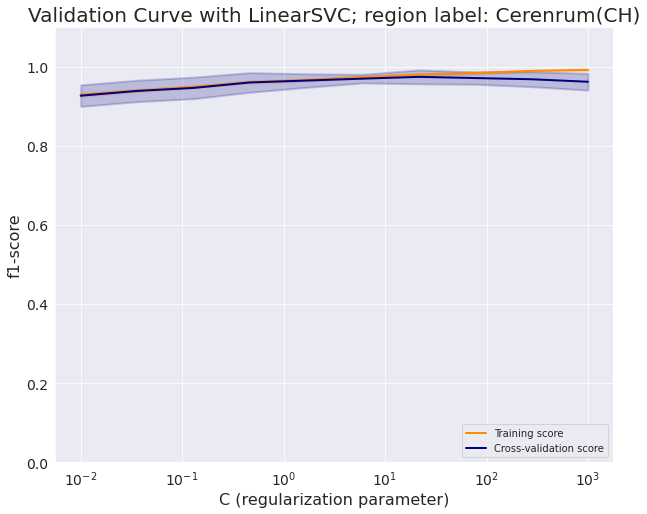

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import validation_curve

param_range = np.logspace(-2, 3, 10)
train_scores, test_scores = validation_curve(
    final_model,
    ph_train,
    y_train,
    param_name="classifier__C",
    param_range=param_range,
    scoring="f1",
    n_jobs=12,
    cv=10
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
# with open('../data/2020_3_og_vs_shuffled_eval_metrics.csv','a') as f:
#     writer = csv.writer(f)
#     writer.writerow(test_scores_mean)
#     writer.writerow(test_scores_std)
#     writer.writerow(train_scores_mean)
#     writer.writerow(train_scores_std)
plt.figure(figsize=(10,8))
plt.title("Validation Curve with LinearSVC; region label: Cerenrum(CH)",fontsize=20)
plt.xlabel("C (regularization parameter)",fontsize=16)
plt.ylabel("f1-score",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="lower right")
# plt.savefig('../data/2020_640_og_vs_shuffled_CV.jpg')
plt.show()

#### Take a deeper look using classification report

In [28]:
from sklearn.metrics import classification_report

## get the output as a dictionary 
# classification_report(y_test, y_predicted, target_names=['0','1'],output_dict=True)

print('Testing Error metrics')
print(classification_report(y_test, model.best_estimator_.predict(ph_test), target_names=['0','1']))
print('\n')
print('Training Error metrics')
print(classification_report(y_train, model.best_estimator_.predict(ph_train), target_names=['0','1']))

Testing Error metrics
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        36
           1       1.00      0.94      0.97        36

    accuracy                           0.97        72
   macro avg       0.97      0.97      0.97        72
weighted avg       0.97      0.97      0.97        72



Training Error metrics
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       321
           1       0.98      0.96      0.97       321

    accuracy                           0.97       642
   macro avg       0.97      0.97      0.97       642
weighted avg       0.97      0.97      0.97       642



#### A more succinct notation to evaluate the performance on the test set

In [29]:
from sklearn.metrics import multilabel_confusion_matrix

multilabel_confusion_matrix(y_test,model.best_estimator_.predict(ph_test))

array([[[34,  2],
        [ 0, 36]],

       [[36,  0],
        [ 2, 34]]])

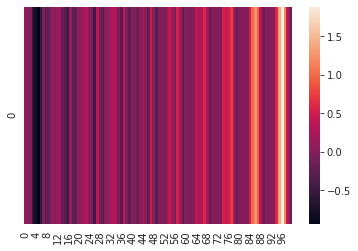

In [26]:
coefs = model.best_estimator_['classifier'].coef_
sns.heatmap(coefs);

## save the model coefs

# import csv

# with open(local_path+"/model_200_4.csv","a") as csvfile:
#     writer=csv.writer(csvfile)
#     for item in pipeline['clf'].coef_:
#         writer.writerow(item)

#### A 2D embedding of networks using TSNE

In [27]:
from sklearn.manifold import TSNE

embedding = TSNE(2)

viz_pipe = Pipeline(steps=[
    ('scaler',gd.representations.DiagramScaler(scalers=[([0,1], MinMaxScaler())])),
    ('tda',gd.representations.Landscape(resolution=10,num_landscapes=10)),
    ('embedding',embedding)
])

X_tsne = viz_pipe.fit_transform(dataset)
y = np.array(y)

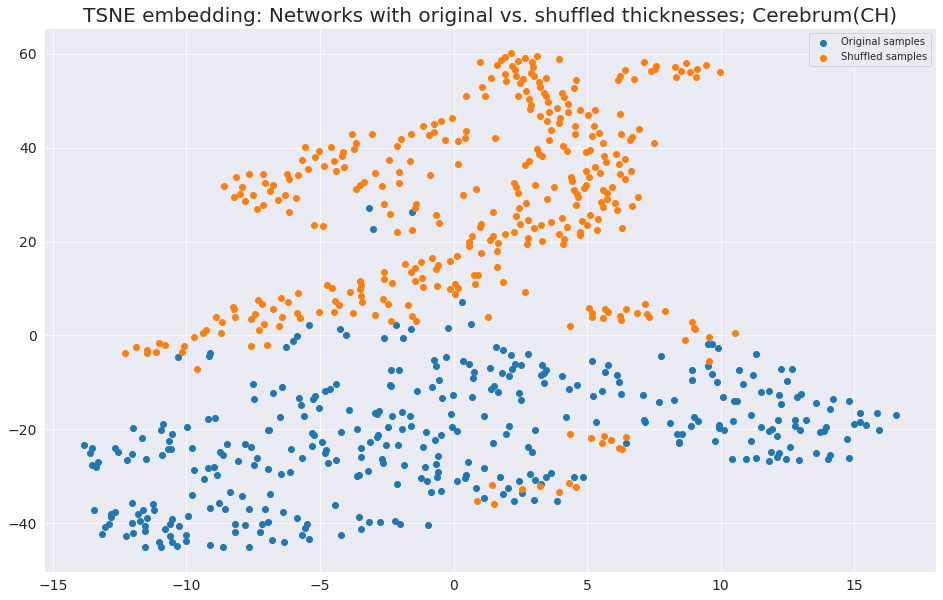

In [29]:
plt.figure(figsize=(16,10))

for i in range(2):
    plt.scatter(X_tsne[y==i,0], X_tsne[y==i,1], label=i)

plt.legend(fontsize=14)
plt.title("TSNE embedding: Networks with original vs. shuffled thicknesses; Cerebrum(CH)", fontsize=20)
plt.legend(['Original samples','Shuffled samples'])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show();
# plt.savefig('../data/2020_3_og_vs_shuffled_tsne.jpg')